In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt

In [2]:
#Jan 12, 2012
today = ql.Date(12, 1, 2012)
ql.Settings.instance().evaluationDate = today

## Helpers

The quotes are hypothestical

In [3]:
Cash_rate = [1.2, 1.3]
Cash_mat = [ql.Period(1,ql.Months), ql.Period(3, ql.Months)]
Cash_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), mat, 0, 
                                ql.UnitedStates(), ql.Following, False, ql.Thirty360())
               for rate, mat in
                zip(Cash_rate, Cash_mat)
               ]

In [4]:
# start date of Eurodollar Future must be the third Wednesday of March, June, September or December
start_date = ql.Date(21, 3, 2012)
Future_helpers = [ql.FuturesRateHelper(ql.QuoteHandle(ql.SimpleQuote(98.2)), 
                start_date, 3, ql.UnitedStates(), ql.Following, False, 
                                      ql.Actual360(), ql.QuoteHandle(ql.SimpleQuote(0.0)))]

In [5]:
Swap_rate = [1.9, 2.0, 2.2, 2.5]
Swap_mat = [ql.Period(1,ql.Years), ql.Period(2, ql.Years), ql.Period(3, ql.Years), ql.Period(5, ql.Years)]

#Libor_Index = ql.IborIndex("USD3M", ql.Period(3, ql.Months), 0, USDCurrency, ql.UnitedStates(), ql.Following, True, ql.Thirty360())
#watch out ql.Semiannual without parentheses; USDLibor need Tenor as the argument
Swap_helpers = [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100.0)), mat, ql.UnitedStates(), 
                ql.Semiannual, ql.Following, ql.Thirty360(), ql.USDLibor(ql.Period(3, ql.Months)))
               for rate, mat in zip(Swap_rate, Swap_mat)]


In [6]:
Helpers = Cash_helpers + Future_helpers + Swap_helpers
yieldcurve_1 = ql.PiecewiseLogCubicDiscount(today, Helpers, ql.Actual360())
yieldcurve_2 = ql.PiecewiseLinearZero(today, Helpers, ql.Actual360())
yieldcurve_3 = ql.PiecewiseCubicZero(today, Helpers, ql.Actual360())
yieldcurve_4 = ql.PiecewiseLogLinearDiscount(today, Helpers, ql.Actual360())

## comparison of different interpolation methods

In [7]:
anchor_dates = yieldcurve_1.dates()
anchor_dates

(Date(12,1,2012),
 Date(13,2,2012),
 Date(12,4,2012),
 Date(21,6,2012),
 Date(17,1,2013),
 Date(17,1,2014),
 Date(20,1,2015),
 Date(17,1,2017))

In [8]:
dfs_1 = []
dfs_2 = []
dfs_3 = []
dfs_4 = []
DCFs = []
ref_date = yieldcurve_1.referenceDate()
print 'reference date: ', ref_date
for date in anchor_dates:
    DCFs.append(ql.ActualActual().yearFraction(ref_date, date))
    dfs_1.append(yieldcurve_1.discount(date))
    dfs_2.append(yieldcurve_2.discount(date))
    dfs_3.append(yieldcurve_3.discount(date))
    dfs_4.append(yieldcurve_4.discount(date))

reference date:  January 12th, 2012


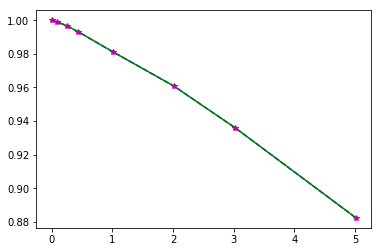

In [9]:
plt.plot(DCFs, dfs_1,"r.", label = 'Cubic Log Discount')
plt.plot(DCFs, dfs_2,"b--", label = 'Linear Zero')
plt.plot(DCFs, dfs_3, 'green', label = 'Cubic Zero')
plt.plot(DCFs, dfs_4, 'm*', label = 'Linear Log Discount')

In [10]:
#generate monthly dates and calculate forward rates
monthly_dates = [ref_date]
num_months = 199
for i in range(num_months):
    #monthly_dates.append(ref_date + ql.Period(i, ql.Weeks))
    monthly_dates.append(monthly_dates[-1] + ql.Period(1, ql.Weeks))

In [11]:
#monthly_dates

In [12]:
fwd_1 = []
fwd_2 = []
fwd_3 = []
fwd_4 = []
tenors = []
#we need .rate() in the end to extract the number
for i in range(50,num_months):
    tenors.append(ql.Thirty360().yearFraction(ref_date, monthly_dates[i]))
    fwd_1.append(yieldcurve_1.forwardRate(monthly_dates[i], monthly_dates[i+1], 
                                         ql.Thirty360(), ql.Continuous).rate())
    fwd_2.append(yieldcurve_2.forwardRate(monthly_dates[i], monthly_dates[i+1], 
                                         ql.Thirty360(), ql.Continuous).rate())
    fwd_3.append(yieldcurve_3.forwardRate(monthly_dates[i], monthly_dates[i+1], 
                                         ql.Thirty360(), ql.Continuous).rate())
    fwd_4.append(yieldcurve_4.forwardRate(monthly_dates[i], monthly_dates[i+1], 
                                         ql.Thirty360(), ql.Continuous).rate())

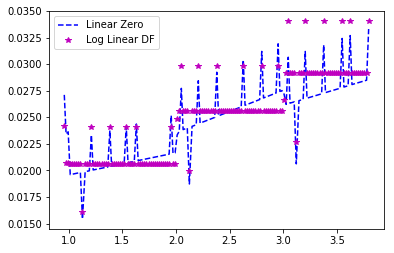

In [13]:
#plt.plot(tenors, fwd_1,"r.", label = 'Cubic Log Discount')
plt.plot(tenors, fwd_2,"b--", label = 'Linear Zero')
#plt.plot(tenors, fwd_3, 'green', label = 'Cubic Zero')
plt.plot(tenors, fwd_4, 'm*', label = 'Log Linear DF')
plt.legend()

This looks more promising, in the sense that loglinearDF interpolation generate stepwise forward rates between each anchor dates. 
But why there are points which are much higher?

In [15]:
for start_date, end, tn,  fwd in zip(monthly_dates[50:-1], monthly_dates[51:], tenors, fwd_4):
    print start_date, "\t\t", end, "\t\t", round(tn, 3), "\t\t", fwd

December 27th, 2012 		January 3rd, 2013 		0.958 		0.0241457427225
January 3rd, 2013 		January 10th, 2013 		0.975 		0.020696350905
January 10th, 2013 		January 17th, 2013 		0.994 		0.020696350905
January 17th, 2013 		January 24th, 2013 		1.014 		0.020625874986
January 24th, 2013 		January 31st, 2013 		1.033 		0.020625874986
January 31st, 2013 		February 7th, 2013 		1.053 		0.020625874986
February 7th, 2013 		February 14th, 2013 		1.069 		0.020625874986
February 14th, 2013 		February 21st, 2013 		1.089 		0.020625874986
February 21st, 2013 		February 28th, 2013 		1.108 		0.020625874986
February 28th, 2013 		March 7th, 2013 		1.128 		0.0160423472113
March 7th, 2013 		March 14th, 2013 		1.153 		0.020625874986
March 14th, 2013 		March 21st, 2013 		1.172 		0.020625874986
March 21st, 2013 		March 28th, 2013 		1.192 		0.020625874986
March 28th, 2013 		April 4th, 2013 		1.211 		0.024063520817
April 4th, 2013 		April 11th, 2013 		1.228 		0.020625874986
April 11th, 2013 		April 18th, 2013 		1.247 

### Looks like the jumps always happen at the month end and the reason being the DayCount Convention used when bootstrap curves and calculate forward curve is different.

The forward rate is calculated using 30/360.
Day count convention of 30/360 means that DCF = 360 * (Y2 - Y1) + 30 * (M2 - M1) + (D2 - D1)
As a result, for month which have days more than 30, DCF is smaller and therefore the forward is bigger. Check March, May, July, August and December. The October, 2013 is normal as the start date is on 31th Oct, 2013. 
Similary, for month of February, DCF is bigger and therefore the forward rate is smaller.

#### change to use the same day count convention

In [16]:
updated_fwd_1 = []
updated_fwd_2 = []
updated_fwd_3 = []
updated_fwd_4 = []
updated_tenors = []
#we need .rate() in the end to extract the number
for i in range(num_months):
    updated_tenors.append(ql.Thirty360().yearFraction(ref_date, monthly_dates[i]))
    updated_fwd_1.append(yieldcurve_1.forwardRate(monthly_dates[i], monthly_dates[i+1], 
                                         ql.Actual360(), ql.Continuous).rate())
    updated_fwd_2.append(yieldcurve_2.forwardRate(monthly_dates[i], monthly_dates[i+1], 
                                         ql.Actual360(), ql.Continuous).rate())
    updated_fwd_3.append(yieldcurve_3.forwardRate(monthly_dates[i], monthly_dates[i+1], 
                                         ql.Actual360(), ql.Continuous).rate())
    updated_fwd_4.append(yieldcurve_4.forwardRate(monthly_dates[i], monthly_dates[i+1], 
                                         ql.Actual360(), ql.Continuous).rate())

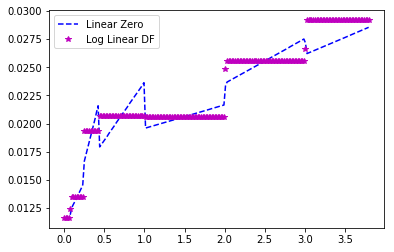

In [17]:
#plt.plot(updated_tenors, updated_fwd_1,"r.", label = 'Cubic Log Discount')
plt.plot(updated_tenors, updated_fwd_2,"b--", label = 'Linear Zero')
#plt.plot(updated_tenors, updated_fwd_3, 'green', label = 'Cubic Zero')
plt.plot(updated_tenors, updated_fwd_4, 'm*', label = 'Log Linear DF')
plt.legend()

## re-pricing of the curve instruments

In [18]:
#need put yield curve into handle class
libor_curve = ql.YieldTermStructureHandle(yieldcurve_4)
libor3M_index = ql.USDLibor(ql.Period(3, ql.Months), libor_curve)
settle_date = ql.UnitedStates().advance(ref_date, 2, ql.Days)
maturity_date = ql.UnitedStates().advance(settle_date, 1, ql.Years)
fixed_leg_tenor = ql.Period(6, ql.Months)
fixed_schedule = ql.Schedule(settle_date, maturity_date, 
                             fixed_leg_tenor, ql.UnitedStates(),
                             ql.Following, ql.Following,
                             ql.DateGeneration.Backward, False)
float_leg_tenor = ql.Period(3, ql.Months)
float_schedule = ql.Schedule (settle_date, maturity_date, 
                              float_leg_tenor, ql.UnitedStates(),
                              ql.Following, ql.Following,
                              ql.DateGeneration.Backward, False)

In [19]:
notional = 10000000
fixed_rate = Swap_rate[0]/100.0 # don't forget divide 100, lol

ir_swap = ql.VanillaSwap(ql.VanillaSwap.Payer, notional, fixed_schedule, 
               fixed_rate, ql.Thirty360(), float_schedule,
               libor3M_index, 0, ql.Actual360())
#Need use the correct daycount convention, 30/360 for fixed leg and Actual/360 for float

In [20]:
swap_engine = ql.DiscountingSwapEngine(libor_curve)
ir_swap.setPricingEngine(swap_engine)

In [21]:
print 'swap PV: ', ir_swap.NPV()
print 'ratio of PV to Notional', ir_swap.NPV()/notional


swap PV:  5.23868948221e-10
ratio of PV to Notional 5.23868948221e-17


In [22]:
for i, d in enumerate(fixed_schedule):
    print i+1, d

1 January 17th, 2012
2 July 17th, 2012
3 January 17th, 2013


In [23]:
for i, d in enumerate(float_schedule):
    print i+1, d

1 January 17th, 2012
2 April 17th, 2012
3 July 17th, 2012
4 October 17th, 2012
5 January 17th, 2013
